<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 7 - Random Forest Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Random Forest Classifier with Simple Features](#rf-simple)  
[Random Forest Classifier with Full Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)      
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the Decision Tree classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'rf'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# Random forest with simple features <a class="anchor" id="rf-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 344 ms, sys: 596 µs, total: 345 ms
Wall time: 345 ms
CPU times: user 95.1 ms, sys: 3.77 ms, total: 98.9 ms
Wall time: 98.3 ms
In-sample score: 92.83%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


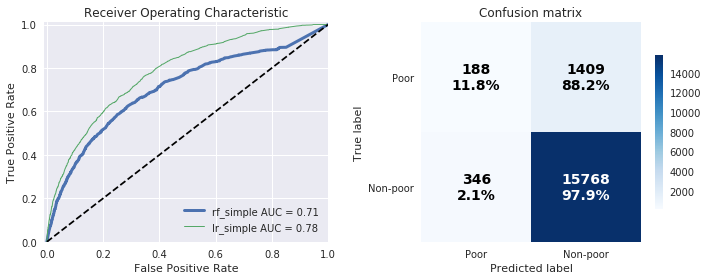

,rf_simple,lr_simple
accuracy,0.900909,0.91158
recall,0.117721,0.0851597
precision,0.35206,0.564315
f1,0.176443,0.147987
cross_entropy,0.616494,0.256817
roc_auc,0.705691,0.781848
cohen_kappa,0.137464,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 3.53% 


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [6]:
feat_imps

,importance
der_nliterate,0.221723
der_nemployedpast3mo,0.197440
der_nchild10under,0.171374
der_nmalesover10,0.125822
der_nfemalesover10,0.114085
hld_toilet__None,0.073199
hld_lighting__PLN electricity,0.051003
cons_029__Yes,0.032503
cons_054__Yes,0.012850


# Random forest with all features <a class="anchor" id="all-feats"></a>

Now let's apply the Random Forest classifier to the dataset with all features. 

CPU times: user 2.35 s, sys: 150 ms, total: 2.5 s
Wall time: 6.19 s
CPU times: user 391 ms, sys: 118 ms, total: 509 ms
Wall time: 1.74 s
In-sample score: 98.73%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


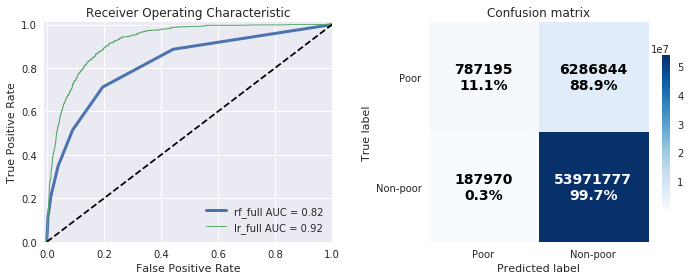

,rf_full,lr_full
accuracy,0.894261,0.910251
recall,0.111279,0.456232
precision,0.807243,0.661838
f1,0.195596,0.540131
cross_entropy,0.669418,0.212947
roc_auc,0.818768,0.923198
cohen_kappa,0.246172,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 7.94% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Class Weighting
The random forest classifier includes the option to balance the classes with `class_weight='balanced'`, so we'll first try this before applying a sampling method. We'll also pick a few parameters to reduce overfitting.

CPU times: user 22.5 s, sys: 246 ms, total: 22.7 s
Wall time: 51.4 s
CPU times: user 2.22 s, sys: 183 ms, total: 2.4 s
Wall time: 4.81 s
In-sample score: 96.01%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


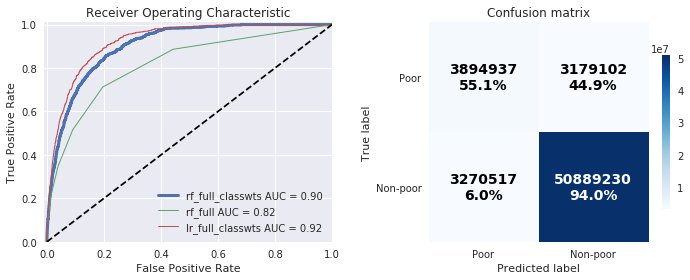

,rf_full_classwts,rf_full,lr_full_classwts
accuracy,0.894672,0.894261,0.830513
recall,0.550596,0.111279,0.866754
precision,0.543572,0.807243,0.39387
f1,0.547061,0.195596,0.541618
cross_entropy,0.285334,0.669418,0.384733
roc_auc,0.904138,0.818768,0.923196
cohen_kappa,0.482144,0.246172,0.428159


Actual poverty rate: 11.38% 
Predicted poverty rate: 14.15% 


In [8]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5, 
                               class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full', 
                                                    'lr_full_classwts'],
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (9584, 453)
CPU times: user 3.88 s, sys: 12.6 ms, total: 3.89 s
Wall time: 6.45 s
CPU times: user 455 ms, sys: 1.42 ms, total: 456 ms
Wall time: 948 ms
In-sample score: 92.34%
CPU times: user 772 ms, sys: 38 ms, total: 810 ms
Wall time: 1.71 s
CPU times: user 750 ms, sys: 34.5 ms, total: 785 ms
Wall time: 1.8 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


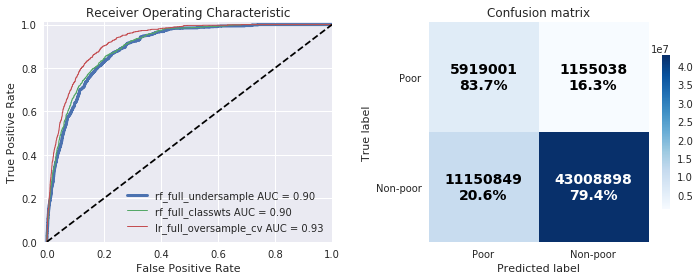

,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.799034,0.894672,0.851611
recall,0.836722,0.550596,0.838116
precision,0.346752,0.543572,0.427456
f1,0.49031,0.547061,0.566159
cross_entropy,0.437278,0.285334,0.348544
roc_auc,0.896729,0.904138,0.925356
cohen_kappa,0.335313,0.482144,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 27.55% 


In [9]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (96680, 453)
CPU times: user 1min 31s, sys: 382 ms, total: 1min 31s
Wall time: 3min 8s
CPU times: user 4.89 s, sys: 113 ms, total: 5 s
Wall time: 8.88 s
In-sample score: 97.64%
CPU times: user 969 ms, sys: 23.8 ms, total: 993 ms
Wall time: 1.27 s
CPU times: user 947 ms, sys: 841 µs, total: 948 ms
Wall time: 1.22 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


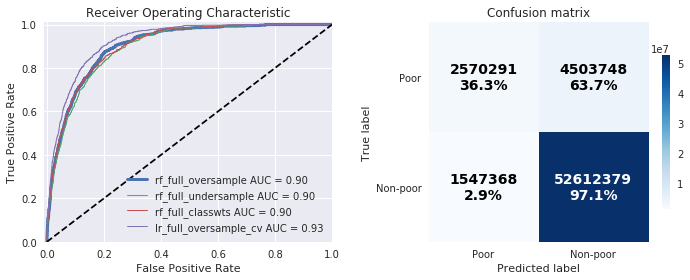

,rf_full_oversample,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.90118,0.799034,0.894672,0.851611
recall,0.363341,0.836722,0.550596,0.838116
precision,0.624212,0.346752,0.543572,0.427456
f1,0.459321,0.49031,0.547061,0.566159
cross_entropy,0.277909,0.437278,0.285334,0.348544
roc_auc,0.904222,0.896729,0.904138,0.925356
cohen_kappa,0.452733,0.335313,0.482144,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 7.64% 


In [10]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>


X shape after undersampling:  (9584, 453)
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.4min finished


CPU times: user 24.5 s, sys: 878 ms, total: 25.4 s
Wall time: 1min 29s
CPU times: user 446 ms, sys: 19.7 ms, total: 466 ms
Wall time: 1.37 s
In-sample score: 90.31%
Best model parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


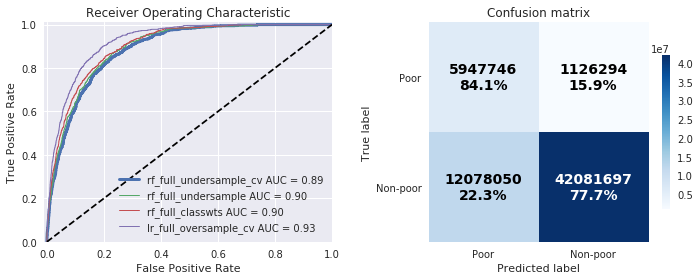

,rf_full_undersample_cv,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.784362,0.799034,0.894672,0.851611
recall,0.840785,0.836722,0.550596,0.838116
precision,0.329957,0.346752,0.543572,0.427456
f1,0.473927,0.49031,0.547061,0.566159
cross_entropy,0.451399,0.437278,0.285334,0.348544
roc_auc,0.889325,0.896729,0.904138,0.925356
cohen_kappa,0.297456,0.335313,0.482144,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 29.66% 


In [11]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 100],
              'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

In [12]:
feat_imps.head(20)

,importance
der_hhsize,0.057343
hld_cooking__Firewood,0.037946
cons_254__Yes,0.037664
hld_refrigerator__Yes,0.036536
hld_nbcell,0.027145
hld_motorcycle__Yes,0.026953
der_nchild10under,0.026665
cons_296__Yes,0.026223
cons_292__Yes,0.025916
geo_district,0.023314


# AdaBoost Random Forest Classifier <a class="anchor" id="ada-boost"></a>

X shape after undersampling:  (9584, 453)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV]  learning_rate=0.01, n_estimators=50, sco

[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  5.8min remaining: 11.6min


[CV]  learning_rate=0.1, n_estimators=50, score=0.8531621790857858, total= 5.7min
[CV]  learning_rate=0.1, n_estimators=50, score=0.8512836568566061, total= 5.7min
[CV]  learning_rate=0.1, n_estimators=100, score=0.8695244055068836, total= 9.3min
[CV]  learning_rate=0.01, n_estimators=100, score=0.8227927363807138, total= 9.4min
[CV]  learning_rate=0.1, n_estimators=100, score=0.8603631809643081, total= 9.5min


[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 10.4min remaining:  3.5min


[CV]  learning_rate=0.01, n_estimators=100, score=0.8318722604884158, total= 9.5min
[CV]  learning_rate=0.01, n_estimators=100, score=0.8307259073842302, total= 9.6min
[CV]  learning_rate=0.1, n_estimators=100, score=0.8619286161552911, total= 9.8min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 10.7min finished


CPU times: user 6min 53s, sys: 1.88 s, total: 6min 55s
Wall time: 20min 13s
CPU times: user 36.4 s, sys: 200 ms, total: 36.6 s
Wall time: 46.9 s
In-sample score: 99.63%
Best model parameters: {'learning_rate': 0.1, 'n_estimators': 100}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


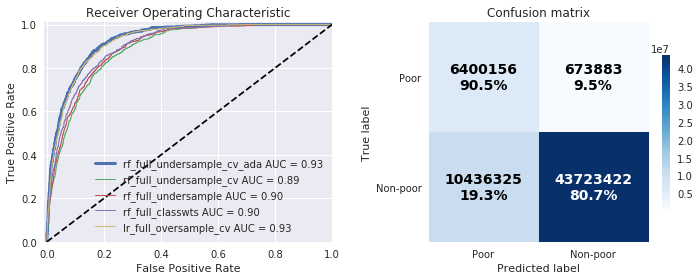

,rf_full_undersample_cv_ada,rf_full_undersample_cv,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.818561,0.784362,0.799034,0.894672,0.851611
recall,0.904739,0.840785,0.836722,0.550596,0.838116
precision,0.380136,0.329957,0.346752,0.543572,0.427456
f1,0.535342,0.473927,0.49031,0.547061,0.566159
cross_entropy,0.530756,0.451399,0.437278,0.285334,0.348544
roc_auc,0.928685,0.889325,0.896729,0.904138,0.925356
cohen_kappa,0.419727,0.297456,0.335313,0.482144,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.58% 


In [13]:
from sklearn.ensemble import AdaBoostClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100], 
              'learning_rate': [0.01, 0.1]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_undersample_cv',
                                                    'rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv_ada', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)
best_model = model.best_estimator_

In [14]:
feat_imps.head(20)

,importance
der_hhsize,0.041828
geo_district,0.033457
der_nchild10under,0.022667
geo_subdistrict,0.019587
geo_village,0.017382
der_nliterate,0.015808
der_nfemalesover10,0.014656
der_nmalesover10,0.011508
hld_nbcell,0.011032
der_nemployedpast3mo,0.009457


# Feature selection <a class="anchor" id="feature-selection"></a>

X shape after feature selection:  (53132, 197)
X shape after undersampling:  (9584, 197)
CPU times: user 4min 2s, sys: 486 ms, total: 4min 3s
Wall time: 5min 14s
CPU times: user 19.1 s, sys: 164 ms, total: 19.3 s
Wall time: 20.3 s
In-sample score: 99.80%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


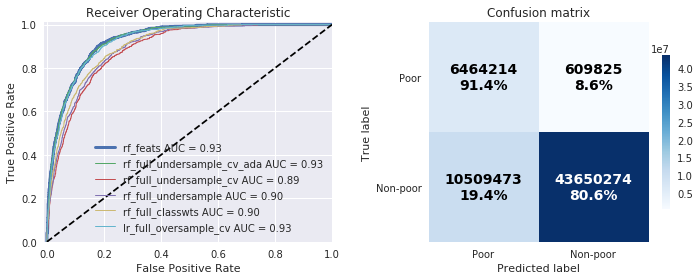

,rf_feats,rf_full_undersample_cv_ada,rf_full_undersample_cv,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.818412,0.818561,0.784362,0.799034,0.894672,0.851611
recall,0.913794,0.904739,0.840785,0.836722,0.550596,0.838116
precision,0.380837,0.380136,0.329957,0.346752,0.543572,0.427456
f1,0.537615,0.535342,0.473927,0.49031,0.547061,0.566159
cross_entropy,0.504015,0.530756,0.451399,0.437278,0.285334,0.348544
roc_auc,0.928638,0.928685,0.889325,0.896729,0.904138,0.925356
cohen_kappa,0.415118,0.419727,0.297456,0.335313,0.482144,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.91% 


In [15]:
feats = feat_imps[feat_imps.cumsum() <= 0.80].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns
print("X shape after feature selection: ", X_train.shape)

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_undersample_cv_ada', 
                                                    'rf_full_undersample_cv',
                                                    'rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

In [16]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

129 consumables features selected:
Gasoline/pertamax
A plate of rice accompanied by a mixture of dishes
Clove filter cigarettes
Lubricant
Ready-made clothes for women
Clothes maintenance material
Powdered/bean coffee
Expenses on gasoline
Broiler egg
Transport expenses
Pork
Other drinks (coffee, milk, etc) 
Instant noodle
Noodle (with meatball/boiled/fried)
Broiler meat
Mobile phone bill
Ready-made clothes for men
Firewood and other fuels
Buildings and land taxes
Clove non filter cigarettes
Chillies
Orange
Cane sugar
Motor vehicle's service and repair
Cassava leaf
Other bread
Soya sauce
Tobacco
Lanzon
Boil or steam cake
Others vegetables
Footwear
Kitchen utensils
Tea
Dryshelled corn/corn rice
Stationery (pen, pencil, eraser, ruler, calculator, dividers, etc)
Others (batteries, storage batteries, matches,..)
Motor and non-motor vehicle taxes
Cosmetic articles and sanitary napkin
Treatment of skin, face, nails, hair
Coconut
Eastern tuna/skipjack tuna
Other fresh fish
School fee
Self treat

# Random Forest Indonesia Summary <a class="anchor" id="summary"></a>



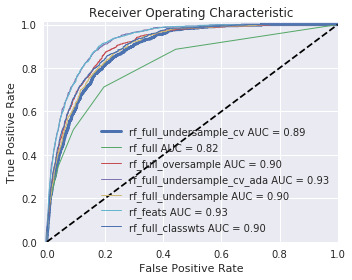

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
rf_full_undersample_cv,0.784362,0.840785,0.329957,0.473927,0.451399,0.889325,0.297456,0.182809
rf_full,0.894261,0.111279,0.807243,0.195596,0.669418,0.818768,0.246172,-0.0343564
rf_full_oversample,0.90118,0.363341,0.624212,0.459321,0.277909,0.904222,0.452733,-0.0374152
rf_full_undersample_cv_ada,0.818561,0.904739,0.380136,0.535342,0.530756,0.928685,0.419727,0.152047
rf_full_undersample,0.799034,0.836722,0.346752,0.49031,0.437278,0.896729,0.335313,0.161696
rf_feats,0.818412,0.913794,0.380837,0.537615,0.504015,0.928638,0.415118,0.155271
rf_full_classwts,0.894672,0.550596,0.543572,0.547061,0.285334,0.904138,0.482144,0.0276643


In [17]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)